In [1]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import numpy as np
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import os
import random

In [2]:
(train_ds, validation_ds, test_ds), metadata = tfds.load('cats_vs_dogs', 
                                                         split=['train[:80%]', 'train[80%:90%]','train[90%:]'],
                                                         with_info=True,
                                                         as_supervised=True)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-04 15:26:57.371182: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-04 15:26:57.371320: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
dataset = train_ds.map(
    lambda image, label: (tf.image.convert_image_dtype(image, tf.float64), label)
    ).take(5)

Image shape:  (262, 350, 3)
Label:  1
Image shape:  (409, 336, 3)
Label:  1
Image shape:  (493, 500, 3)
Label:  1
Image shape:  (375, 500, 3)
Label:  0
Image shape:  (240, 320, 3)
Label:  1


2023-03-04 15:27:03.271220: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


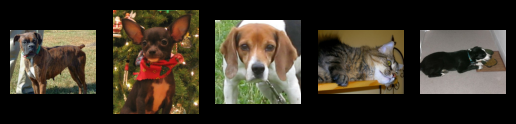

In [4]:
f, axarr = plt.subplots(1,5)

i = 0
for image, label in dataset:
  print('Image shape: ', np.shape(image))
  tf.print('Label: ', label)
  axarr[i].imshow(image)
  axarr[i].axis('off')
  i += 1

In [5]:
rnd = np.random.RandomState(seed=1234)
# we need to convert images to same shape
# we need to convert images to same shape
IMG_HEIGHT = 224
IMG_WIDTH = 224

train = train_ds.map(
    lambda image, label: (tf.image.convert_image_dtype(image, tf.float64), label)
).map( # resize for input
      lambda image, label: (tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH]), label)
).map( # random horizontal fip
      lambda image, label: (tf.image.random_flip_left_right(image, seed=rnd.seed(1234)), label)
).map( # random translation
      lambda image, label: (tfa.image.translate(image, tf.random.normal(shape=[2], seed=1234)), label)
).take(5)

Image shape:  (224, 224, 3)
Label: 1
Image shape:  (224, 224, 3)
Label: 1
Image shape:  (224, 224, 3)
Label: 1
Image shape:  (224, 224, 3)
Label: 0
Image shape:  (224, 224, 3)
Label: 1


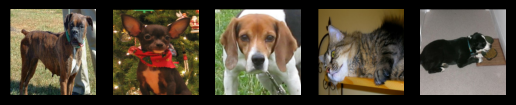

In [6]:
f, axarr = plt.subplots(1,5)

i = 0
for image, label in train:
  print('Image shape: ', np.shape(image))
  tf.print('Label:',label)
  axarr[i].imshow(image)
  axarr[i].axis('off')
  i += 1

In [75]:
rnd = np.random.RandomState(seed=None)
num_threads = 4

# putting all the data processing pipeline on the CPU 
# to make sure that the GPU is only used for training the deep neural network model
with tf.device('/cpu:0'):
    train = train_ds.map(
         lambda image, label: (tf.image.convert_image_dtype(image, tf.float64), label)
         ).map( # resize for input
         lambda image, label: (tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH]), label)
         ).map( # random horizontal fip
         lambda image, label: (tf.image.random_flip_left_right(image, seed=rnd.seed(1234)), label), num_parallel_calls=num_threads
         ).map( # random translation
         lambda image, label: (tfa.image.translate(image, tf.random.normal(shape=[2], seed=rnd.seed(1234))), label), num_parallel_calls=num_threads
         ).shuffle(1000).batch(32).take(1).prefetch(1)

with tf.device('/cpu:0'):
     valid = validation_ds.map(
          lambda image, label: (tf.image.convert_image_dtype(image, tf.float64), label)
          ).map( # resize for input
          lambda image, label: (tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH]), label)
          ).map( # random horizontal fip
          lambda image, label: (tf.image.random_flip_left_right(image, seed=rnd.seed(1234)), label), num_parallel_calls=num_threads
          ).map( # random translation
          lambda image, label: (tfa.image.translate(image, tf.random.normal(shape=[2], seed=rnd.seed(1234))), label), num_parallel_calls=num_threads
          ).repeat().batch(128).take(1).cache( # cache images
          ).prefetch(1)

test = test_ds.map(
    lambda image, label: (tf.image.convert_image_dtype(image, tf.float64), label)
).map( # resize for input
      lambda image, label: (tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH]), label)
).cache( # cache images
).map( # random horizontal fip
      lambda image, label: (tfa.image.translate(image, tf.random.normal(shape=[2], seed=rnd.seed(1234))), label)
).map( # random translation
      lambda image, label: (tf.image.rgb_to_grayscale(image), label)
).shuffle(100).prefetch(1)

In [76]:
# Using pre trained MobileNetV2 model
# this model is trained on 224x224 images
mobnet = tf.keras.applications.MobileNetV2(include_top=False, weights=None)

# trainable parameters in model
nvar = len(mobnet.trainable_variables)
print('Number of variables: ', nvar)
for i in np.arange(nvar):
  print(mobnet.trainable_variables[i].name) # variable name
  print(mobnet.trainable_variables[i].shape) # kernel shape

Number of variables:  156
Conv1/kernel:0
(3, 3, 3, 32)
bn_Conv1/gamma:0
(32,)
bn_Conv1/beta:0
(32,)
expanded_conv_depthwise/depthwise_kernel:0
(3, 3, 32, 1)
expanded_conv_depthwise_BN/gamma:0
(32,)
expanded_conv_depthwise_BN/beta:0
(32,)
expanded_conv_project/kernel:0
(1, 1, 32, 16)
expanded_conv_project_BN/gamma:0
(16,)
expanded_conv_project_BN/beta:0
(16,)
block_1_expand/kernel:0
(1, 1, 16, 96)
block_1_expand_BN/gamma:0
(96,)
block_1_expand_BN/beta:0
(96,)
block_1_depthwise/depthwise_kernel:0
(3, 3, 96, 1)
block_1_depthwise_BN/gamma:0
(96,)
block_1_depthwise_BN/beta:0
(96,)
block_1_project/kernel:0
(1, 1, 96, 24)
block_1_project_BN/gamma:0
(24,)
block_1_project_BN/beta:0
(24,)
block_2_expand/kernel:0
(1, 1, 24, 144)
block_2_expand_BN/gamma:0
(144,)
block_2_expand_BN/beta:0
(144,)
block_2_depthwise/depthwise_kernel:0
(3, 3, 144, 1)
block_2_depthwise_BN/gamma:0
(144,)
block_2_depthwise_BN/beta:0
(144,)
block_2_project/kernel:0
(1, 1, 144, 24)
block_2_project_BN/gamma:0
(24,)
block_2_pr

In [77]:
# clear keras session
tf.keras.backend.clear_session()

## Training from scratch

We are going to add a dropout layer and a new dense layer for 2 classes (i.e., cats and dogs)


In [78]:
dropout_rate = 0.2
num_classes = 2
CHANS = 3 # number of channels in input images
input_shape = [IMG_HEIGHT, IMG_WIDTH, CHANS]

mbnet = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights=None) 

model = tf.keras.Sequential([
  mbnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(num_classes, activation='softmax')
], name='pre-trained_mobilenetV2')
model.build()

model.summary()

Model: "pre-trained_mobilenetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


In [79]:
with tf.GradientTape() as tape:
  tape.reset()

In [81]:
LR = 0.001 # learning rate
optimizer = tf.optimizers.Adam(learning_rate=LR) # adam optimizer

def train_step(model, X, Y):
  with tf.GradientTape() as tape:
    pred = model(X)
    current_loss = tf.reduce_mean(tf.losses.categorical_crossentropy(Y, pred))
  grads = tape.gradient(current_loss, model.trainable_variables) 
  optimizer.apply_gradients(zip( grads , model.trainable_variables)) # update gradients of all layers
  current_accuracy = tf.reduce_mean(tf.metrics.categorical_accuracy(Y, pred))
  return(current_loss, current_accuracy)

In [82]:
import warnings
warnings.filterwarnings('ignore')

In [83]:
niter = 1000

tloss = []
tacc = []
vloss = []
vacc = []

for it in range(niter):
    for image, label in train:
        loss, acc = train_step( model , image , tf.one_hot(label, depth=2) ) #run training

    if it % 10 == 0: #log training metrics
      tf.print('iter: ',it, ', loss: {:.3f}, acc: {:.3f}'.format(loss, acc))
      tloss.append(loss)
      tacc.append(acc)

    if it % 50 == 0: #log validation metrics
      for val_image, val_label in valid:
        val_pred = model(val_image)
        val_loss = tf.reduce_mean(tf.losses.categorical_crossentropy(tf.one_hot(val_label, depth=2), val_pred))
        val_acc = tf.reduce_mean(tf.metrics.categorical_accuracy(tf.one_hot(val_label, depth=2), val_pred))
        tf.print('iter: ',it, ', validation loss: {:.3f}, validation acc: {:.3f}'.format(val_loss, val_acc))
        vloss.append(val_loss)
        vacc.append(val_acc)

iter:  0 , loss: 0.693, acc: 0.438
iter:  0 , validation loss: 0.691, validation acc: 0.555
iter:  10 , loss: 0.693, acc: 0.531
iter:  20 , loss: 0.693, acc: 0.531
iter:  30 , loss: 0.693, acc: 0.500
iter:  40 , loss: 0.694, acc: 0.469
iter:  50 , loss: 0.691, acc: 0.594
iter:  50 , validation loss: 0.695, validation acc: 0.445
iter:  60 , loss: 0.693, acc: 0.500
iter:  70 , loss: 0.686, acc: 0.594
iter:  80 , loss: 0.689, acc: 0.562
iter:  90 , loss: 0.690, acc: 0.562
iter:  100 , loss: 0.690, acc: 0.562
iter:  100 , validation loss: 0.697, validation acc: 0.445
iter:  110 , loss: 0.691, acc: 0.531
iter:  120 , loss: 0.691, acc: 0.531
iter:  130 , loss: 0.701, acc: 0.406
iter:  140 , loss: 0.696, acc: 0.438
iter:  150 , loss: 0.692, acc: 0.531
iter:  150 , validation loss: 0.697, validation acc: 0.445
iter:  160 , loss: 0.690, acc: 0.562
iter:  170 , loss: 0.690, acc: 0.594
iter:  180 , loss: 0.693, acc: 0.500
iter:  190 , loss: 0.688, acc: 0.625
iter:  200 , loss: 0.697, acc: 0.438
i

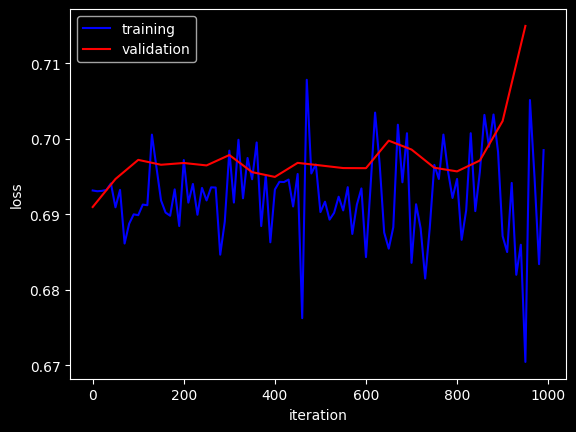

In [84]:
titers = 10*np.arange(np.shape(tloss)[0])
viters = 50*np.arange(np.shape(vloss)[0])

plt.plot(titers, tloss, c='b', label='training');
plt.plot(viters, vloss, c='r', label='validation');
plt.legend();
plt.xlabel('iteration');
plt.ylabel('loss');

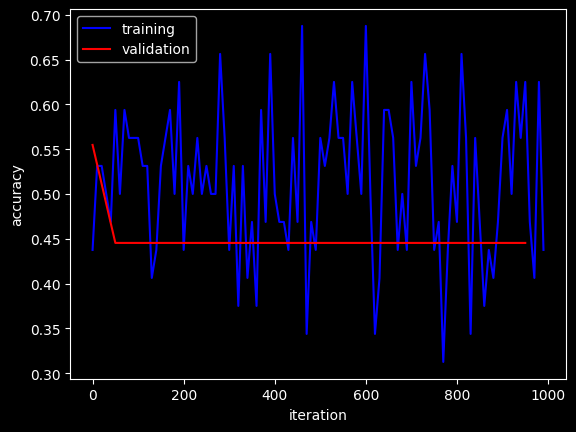

In [85]:
plt.plot(titers, tacc, c='b', label='training');
plt.plot(viters, vacc, c='r', label='validation');
plt.legend();
plt.xlabel('iteration');
plt.ylabel('accuracy');

## Transfer learning
Now we will implement transfer learning from the imagenet weights

In [86]:
tf.keras.backend.clear_session() # clear keras session

In [87]:
dropout_rate = 0.2
num_classes = 2
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANS = 3
input_shape = [IMG_HEIGHT, IMG_WIDTH, CHANS]

mobnet = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

model = tf.keras.Sequential([
    mobnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(num_classes, activation='softmax')
], name='MobileNetV2_weights_model')

model.build()

mobnet.trainable = False # freezes the first layers to the imagenet weights

model.summary()

Model: "MobileNetV2_weights_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [88]:
with tf.GradientTape() as tape:
    tape.reset() # This resets gradient tape

In [89]:
LR = 1e-2 # learning rate
optimizer = tf.keras.optimizers.Adam(LR) # initilaize adam optimizer

def train_step(model, X, Y):
    with tf.GradientTape() as tape:
        pred = model( X )
        current_loss = tf.reduce_mean(tf.losses.categorical_crossentropy( Y,  pred))
    grads = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients( zip( grads , model.trainable_variables) )
    current_accuracy = tf.reduce_mean(tf.metrics.categorical_accuracy(Y, pred))
    return(current_loss, current_accuracy)

In [90]:
niter = 1000

tloss = []
tacc = []
vloss = []
vacc = []

for it in range(niter):
    for image, label in train:
        loss, acc = train_step(model , image , tf.one_hot(label,depth=2) ) #run training

    if it % 10 == 0: #log training metrics
      tf.print('iter: ',it, ', loss: {:.3f}, acc: {:.3f}'.format(loss, acc))
      tloss.append(loss)
      tacc.append(acc)

    if it % 50 == 0: #log validation metrics
      for val_image, val_label in valid:
        val_pred = model(val_image)
        val_loss = tf.reduce_mean(tf.losses.categorical_crossentropy(tf.one_hot(val_label,depth=2) , val_pred))
        val_acc = tf.reduce_mean(tf.metrics.categorical_accuracy(tf.one_hot(val_label,depth=2) , val_pred))
        tf.print('iter: ',it, ', validation loss: {:.3f}, validation acc: {:.3f}'.format(val_loss, val_acc))
        vloss.append(val_loss)
        vacc.append(val_acc)

iter:  0 , loss: 0.839, acc: 0.438
iter:  0 , validation loss: 0.703, validation acc: 0.695
iter:  10 , loss: 0.054, acc: 0.969
iter:  20 , loss: 0.063, acc: 0.969
iter:  30 , loss: 0.086, acc: 0.938
iter:  40 , loss: 0.023, acc: 1.000
iter:  50 , loss: 0.000, acc: 1.000
iter:  50 , validation loss: 0.003, validation acc: 1.000
iter:  60 , loss: 0.002, acc: 1.000
iter:  70 , loss: 0.001, acc: 1.000
iter:  80 , loss: 0.029, acc: 1.000
iter:  90 , loss: 0.088, acc: 0.969
iter:  100 , loss: 0.006, acc: 1.000
iter:  100 , validation loss: 0.047, validation acc: 0.984
iter:  110 , loss: 0.022, acc: 1.000
iter:  120 , loss: 0.211, acc: 0.938
iter:  130 , loss: 0.003, acc: 1.000
iter:  140 , loss: 0.000, acc: 1.000
iter:  150 , loss: 0.004, acc: 1.000
iter:  150 , validation loss: 0.560, validation acc: 0.914
iter:  160 , loss: 0.000, acc: 1.000
iter:  170 , loss: 0.000, acc: 1.000
iter:  180 , loss: 0.000, acc: 1.000
iter:  190 , loss: 0.020, acc: 1.000
iter:  200 , loss: 0.015, acc: 1.000
i

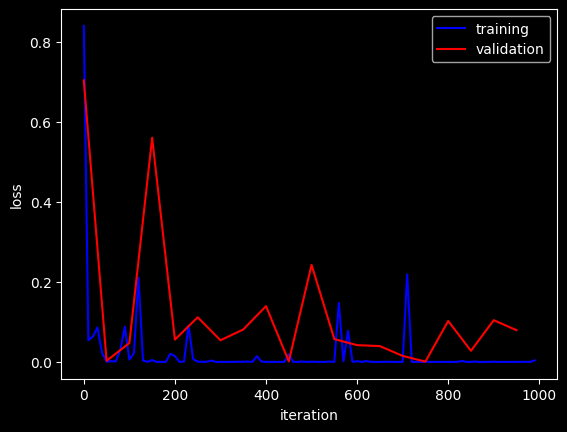

In [91]:
# plot training and validation loss as a function of iteration
titers = 10*np.arange(np.shape(tloss)[0])
viters = 50*np.arange(np.shape(vloss)[0])

plt.plot(titers, tloss, c='b', label='training');
plt.plot(viters, vloss, c='r', label='validation');
plt.legend();
plt.xlabel('iteration');
plt.ylabel('loss');

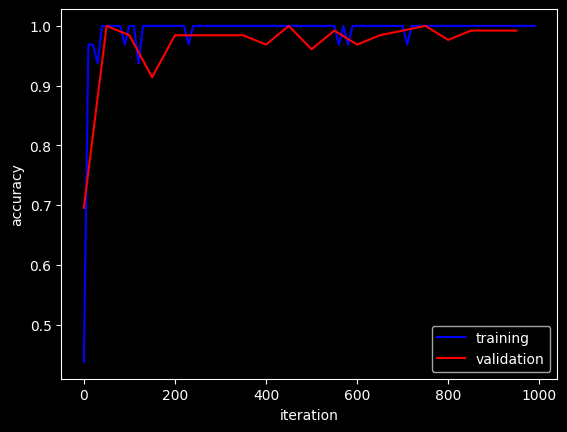

In [92]:
# plot training and validation accuracy as a function of iteration
plt.plot(titers, tacc, c='b', label='training');
plt.plot(viters, vacc, c='r', label='validation');
plt.legend();
plt.xlabel('iteration');
plt.ylabel('accuracy');

## Save weights

In [93]:
# Lets save the trained weights into hdf5 format
import os
CODE_PATH = '/Users/rahuln/vscode/'
MODEL_PATH = os.path.join(CODE_PATH, 'mlis_workshops', 'workshop4', 'my_weights.hdf5')
model.save_weights(MODEL_PATH)


In [94]:
tf.keras.backend.clear_session()

## Load weights

In [95]:
# Load previously saved weights onto new model

dropoutrate = 0.2
num_classes = 2
input_shape = [IMG_HEIGHT, IMG_WIDTH, CHANS]

mobnet = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet') #We now dont want randomized weights but to load weights from imagenet

model = tf.keras.Sequential([
  mobnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(num_classes, activation='softmax') 
], name='loaded_sequential_model')
model.build()

mobnet.trainable = False # freeze the first layers to the imagenet weights

model.summary() # print the model

Model: "loaded_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [96]:
# Fine tuning the model by training with a smaller learning rate

LR = 1e-5 # learning rate
optimizer = tf.optimizers.Adam(LR) # adam optimizer

def train_step( model, X , Y):
    with tf.GradientTape() as tape:
        pred = model( X )
        current_loss = tf.reduce_mean(tf.losses.categorical_crossentropy( Y,  pred))
    grads = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients( zip( grads , model.trainable_variables) )
    current_accuracy = tf.reduce_mean(tf.metrics.categorical_accuracy(Y, pred))
    return(current_loss, current_accuracy)

In [97]:
niter = 1000

tloss = []
tacc = []
vloss = []
vacc = []

for it in range(niter):
    for image, label in train:
        loss, acc = train_step( model , image , tf.one_hot(label,depth=2) ) #run training

    if it % 10 is 0: #log training metrics
      tf.print('iter: ',it, ', loss: {:.3f}, acc: {:.3f}'.format(loss, acc))
      tloss.append(loss)
      tacc.append(acc)

    if it % 50 is 0: #log validation metrics
      for val_image, val_label in valid:
        val_pred = model(val_image)
        val_loss = tf.reduce_mean(tf.losses.categorical_crossentropy(tf.one_hot(val_label,depth=2) , val_pred))
        val_acc = tf.reduce_mean(tf.metrics.categorical_accuracy(tf.one_hot(val_label,depth=2) , val_pred))
        tf.print('iter: ',it, ', validation loss: {:.3f}, validation acc: {:.3f}'.format(val_loss, val_acc))
        vloss.append(val_loss)
        vacc.append(val_acc)

iter:  0 , loss: 0.889, acc: 0.438
iter:  0 , validation loss: 0.794, validation acc: 0.500
iter:  10 , loss: 0.721, acc: 0.562
iter:  20 , loss: 0.710, acc: 0.594
iter:  30 , loss: 0.650, acc: 0.625
iter:  40 , loss: 0.869, acc: 0.438
iter:  50 , loss: 0.816, acc: 0.562
iter:  50 , validation loss: 0.745, validation acc: 0.531
iter:  60 , loss: 0.789, acc: 0.500
iter:  70 , loss: 0.605, acc: 0.656
iter:  80 , loss: 0.616, acc: 0.719
iter:  90 , loss: 0.574, acc: 0.750
iter:  100 , loss: 0.522, acc: 0.750
iter:  100 , validation loss: 0.701, validation acc: 0.617
iter:  110 , loss: 0.512, acc: 0.719
iter:  120 , loss: 0.641, acc: 0.625
iter:  130 , loss: 0.630, acc: 0.531
iter:  140 , loss: 0.591, acc: 0.594
iter:  150 , loss: 0.447, acc: 0.812
iter:  150 , validation loss: 0.658, validation acc: 0.641
iter:  160 , loss: 0.563, acc: 0.688
iter:  170 , loss: 0.571, acc: 0.688
iter:  180 , loss: 0.614, acc: 0.719
iter:  190 , loss: 0.674, acc: 0.625
iter:  200 , loss: 0.502, acc: 0.781
i

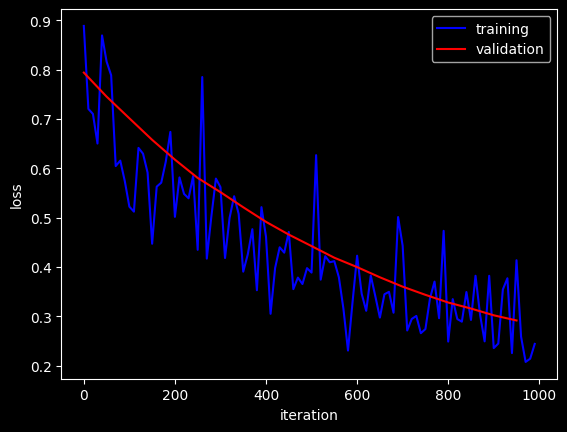

In [98]:
# plot training and validation loss as a function of iteration
titers = 10*np.arange(np.shape(tloss)[0])
viters = 50*np.arange(np.shape(vloss)[0])

plt.plot(titers, tloss, c='b', label='training');
plt.plot(viters, vloss, c='r', label='validation');
plt.legend();
plt.xlabel('iteration');
plt.ylabel('loss');

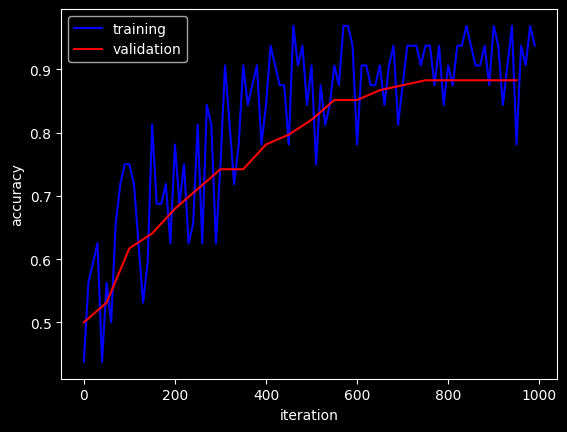

In [99]:
plt.plot(titers, tacc, c='b', label='training');
plt.plot(viters, vacc, c='r', label='validation');
plt.legend();
plt.xlabel('iteration');
plt.ylabel('accuracy');